# INF8111 - Fouille de donn√©es


## TP1 √ât√© 2024 - Duplicate Bug Report Detection

##### Date de remise: 19/05 √† 23:55

##### La note TP sera p√©nalis√©e de 10 points si le notebook met plus d'1h √† s'ex√©cuter. 



#### Membres de l'√©quipe:

    - Nom (Matricule) 1
    - Nom (Matricule) 2
    - Nom (Matricule) 3
    
##### Deliverables:

Vous devez soumettre deux fichiers distincts sur Moodle: 
1. Ce notebook
2. Un [Json](https://en.wikipedia.org/wiki/JSON) contenant du contenu de page Web r√©cup√©r√© (bug_reports.json) 
    


## R√©sum√©

En raison de la complexit√© des syst√®mes logiciels, les bogues logiciels sont r√©pandus. Les entreprises, en particulier les grandes, utilisent g√©n√©ralement un syst√®me de suivi des bogues (BTS), √©galement appel√© syst√®me de suivi des probl√®mes, pour g√©rer et suivre les enregistrements des bogues. Outre les d√©veloppeurs et les testeurs, de nombreux projets, principalement des projets open source, permettent aux utilisateurs de signaler de nouveaux bogues dans leur BTS. Pour ce faire, les utilisateurs doivent remplir un formulaire avec plusieurs champs. Un sous-ensemble important de ces champs fournissent des donn√©es cat√©gorielles et n'acceptent que les valeurs d'une liste fixe d‚Äôoptions (par exemple, composant, version et produit du syst√®me). Deux autres domaines importants sont le r√©sum√© et la description. Les utilisateurs sont libres d'√©crire ce qu'ils veulent dans ces deux champs avec la seule contrainte que le r√©sum√© ne d√©passe pas un nombre maximal de caract√®res. La soumission d'un formulaire cr√©e une page, appel√©e rapport de bogue ou rapport de probl√®me, qui contient toutes les informations sur un bogue.

En raison du manque de communication et de synchronisation, les utilisateurs peuvent ne pas savoir qu'un bogue sp√©cifique a d√©j√† √©t√© soumis et le signalent √† nouveau. Identifier les rapports de bogues en double est une t√¢che importante dans les BTS et c'est le sujet de ce TP. Fondamentalement, notre objectif est de d√©velopper un syst√®me qui pr√©dit si une paire de nouveau rapport de bogue et un rapport de bogue soumis sont dupliqu√© ou non. Ce syst√®me sera utilis√© pour identifier manuellement les rapports dupliqu√©.

# 2 Pr√©requis

Pour ce TP, vous aurez besoin des librairies `numpy` et `sklearn`, ainsi que la librairie `nltk`, qui est une libraire utilis√©e pour faire du traitement du language (Natural Language Processing, NLP)

Installez les libraires en question et ex√©cutez le code ci-dessous :

In [1]:
# If you want, you can use anaconda and install after nltk library
!pip install --user numpy
!pip install --user scikit-learn
!pip install --user nltk
!pip install --user bs4
%pip install lxml
%pip install beautifulsoup4

#python
import nltk
nltk.download("punkt")

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\oussa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# 3 - Les donn√©es

T√©l√©chargez l'archive √† l'adresse suivante: https://www.dropbox.com/s/s53fqz29z8ch4ip/data.zip?dl=0

L'archive contient: 

1. training.txt : ce fichier contient des paires de rapports de bogues qui seront utilis√©s pour entra√Æner notre syst√®me.
2. validation.txt : Ce fichier contient des paires de rapports de bogues qui seront utilis√©s pour √©valuer notre syst√®me.
2. bug_reports : Ce dossier contient le code HTML des rapports de bogues. Chaque fichier HTML est nomm√© selon le motif **bug_report_id.html**.


L'image ci-dessous illustre un exemple de bug report:



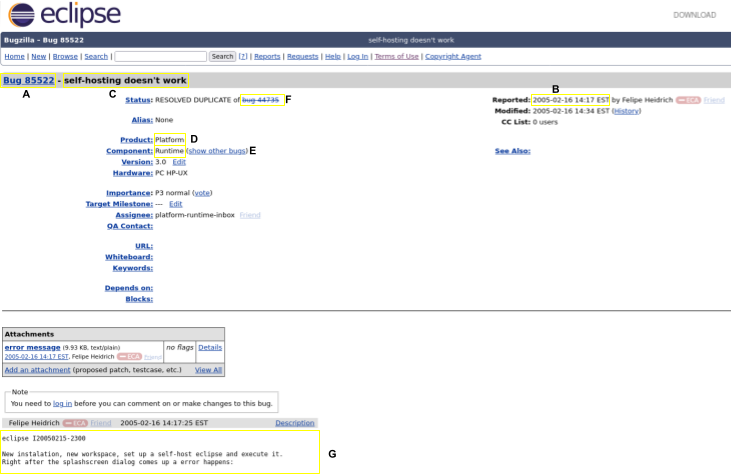

In [2]:
from IPython import display
display.Image("https://irving-muller.github.io/images/bug-report-eclipse.png")

- A : identifiant du bug report
- B : date de cr√©ation
- C : r√©sum√©
- D : produit
- E : composant
- F : l'identifiant du rapport dont le bug report est dupliqu√©
- G : description


Le script suivant charge le jeu de donn√©es de test et d√©finit certaines variables globales:

In [3]:
import os

# d√©finir le chemin du dossier qui contient les donn√©es 
FOLDER_PATH = "data/"
PAGE_FOLDER = os.path.join(FOLDER_PATH, 'bug_reports')


# Charger l'ensemble de donn√©es d'√©valuation 
import json


training_file = open(os.path.join(FOLDER_PATH, "training.txt"))
validation_file = open(os.path.join(FOLDER_PATH, "validation.txt"))
word_vec_path = os.path.join(FOLDER_PATH, "glove.42B.300d_clear.txt")

def read_dataset(f):
    for line in f:
        line = line.strip()
        
        if len(line) == 0:
            continue
        
        rep1, rep2, label = line.split(',')

        rep1 = int(rep1)
        rep2 = int(rep2)
        label = 1.0 if int(label) > 0 else 0.0 
        
        yield (rep1, rep2, label)
    
    


training_pairs = list(read_dataset(training_file))
validation_pairs = list(read_dataset(validation_file))

training_reports_set = set()


for r1, r2, _ in training_pairs:
    training_reports_set.add(r1)
    training_reports_set.add(r2)

# 4 - Web scraping

"Le *web scraping* (parfois appel√© harvesting) est une technique d'extraction du contenu de sites Web, via un script ou un programme, dans le but de le transformer pour permettre son utilisation dans un autre contexte, par exemple le r√©f√©rencement." [Wikipedia](https://fr.wikipedia.org/wiki/Web_scraping)


## 4.1 - Question 1 (4 points)

Impl√©mentez la fonction *extract_data_from_page* qui extrait les informations suivantes du code HTML: l'ID du bug report, la date de cr√©ation, le titre, le produit, le composant, l'ID du bug report dont il est un duplicata, et la description.

La fonction *extract_data_from_page* retourne un dictionnaire avec la structure suivante:

```python
 {"report_id": int, 
  "dup_id": int or None (the report id which it is duplicate), 
  "component": string, 
  "product": string, 
  "summary": string, 
  "description": string, 
  "creation_date": string} 
```

Par exemple, pour le bug report "bug_report/18431.html", la fonction *extract_data_from_page* retourne:
 
```python
{'report_id': 18431,
 'dup_id': 27227,
 'component': 'GEF-Legacy Draw2d',
 'product': 'GEF',
 'summary': 'Polylines ignored by FLowLayout',
 'description': 'I tried a poor sample but it\'s not working the way I thought it would be. Look \nat the following source. I have a figure with FlowLayout and add 2 polylines to \nit but the polylines aren\'t arranged in FlowLayout. Both polylines are pushed \ninto the first flow element. Any ideas why?\n\n\n\npublic static void main(String args[])\n{\n Shell shell = new Shell();\n shell.open();\n shell.setText("draw2d Figures");\n\n LightweightSystem lws = new LightweightSystem(shell);\n\n IFigure panel = new Figure();\n panel.setLayoutManager( new FlowLayout(FlowLayout.HORIZONTAL) );\n\n lws.setContents(panel);\n\n Polyline polyline = new Polyline();\n polyline.setStart(new Point( 5, 5));\n polyline.addPoint(new Point( 5, 45));\n polyline.addPoint(new Point( 45, 45));\n polyline.addPoint(new Point( 45, 5));\n panel.add(polyline);\n\n Polyline polyline2 = new Polyline();\n polyline2.setStart(new Point( 5, 5));\n polyline2.addPoint(new Point( 45, 45));\n panel.add(polyline2);\n\n Display display = Display.getDefault();\n while( !shell.isDisposed() )\n {\n  if( !display.readAndDispatch() )\n   display.sleep();\n }\n\n}',
 'creation_date': '2002-05-31 09:17 EDT'}
```

**La date de cr√©ation doit √™tre repr√©sent√©e sous la forme d'un "ann√©e-mois-jour heure:minute fuseau horaire". Si un bug report n'est pas un duplicata, alors dup_id doit √™tre None.**

*Indice: lxml parse est plus rapide que html.parser*

In [4]:
from bs4 import BeautifulSoup
import re

def extract_data_from_page(pagepath):
    with open(pagepath, 'r', encoding='utf-8') as file:
        soup = BeautifulSoup(file, 'lxml')
    
    # extraction du report_id
    report_id = int(soup.title.text.split('‚Äì')[0].strip())

    # extraction du dup_id
    dup_id = None
    status_text = soup.find(id='bz_field_status')
    if status_text and "duplicate" in status_text.text.lower():
        duplicate_link = status_text.find('a', class_='bz_bug_link')
        if duplicate_link:
            dup_id_match = re.search(r'id=(\d+)', duplicate_link['href'])
            if dup_id_match:
                dup_id = int(dup_id_match.group(1))

    # extraction du component
    component = soup.find(id='field_container_component')
    if component:
        component = component.text.split('\n')[0].strip()

    # extraction du product
    product = soup.find(id='field_container_product').text.strip() if soup.find(id='field_container_product') else None

    # extraction du summary
    summary = soup.find(id='summary_input')
    if summary:
        summary = summary.text.strip()
        summary = summary.replace('Summary:', '').strip()

    # extraction de la description
    description = soup.find('pre', class_='bz_comment_text')
    if description:
        description = description.text.strip()

    # extraction de la date de cr√©ation
    creation_date = soup.find('span', class_='bz_comment_time')
    if creation_date:
        creation_date = creation_date.text.strip()

    return {
        "report_id": report_id,
        "dup_id": dup_id,
        "component": component,
        "product": product,
        "summary": summary,
        "description": description,
        "creation_date": creation_date
    }

# test de la fonction extract_data_from_page
path_to_html = r'data/bug_reports/18431.html'
data = extract_data_from_page(path_to_html)
print(data)


{'report_id': 18431, 'dup_id': 27227, 'component': 'GEF-Legacy Draw2d', 'product': 'GEF', 'summary': 'Polylines ignored by FLowLayout', 'description': 'I tried a poor sample but it\'s not working the way I thought it would be. Look \nat the following source. I have a figure with FlowLayout and add 2 polylines to \nit but the polylines aren\'t arranged in FlowLayout. Both polylines are pushed \ninto the first flow element. Any ideas why?\n\n\n\npublic static void main(String args[])\n{\n Shell shell = new Shell();\n shell.open();\n shell.setText("draw2d Figures");\n\n LightweightSystem lws = new LightweightSystem(shell);\n\n IFigure panel = new Figure();\n panel.setLayoutManager( new FlowLayout(FlowLayout.HORIZONTAL) );\n\n lws.setContents(panel);\n\n Polyline polyline = new Polyline();\n polyline.setStart(new Point( 5, 5));\n polyline.addPoint(new Point( 5, 45));\n polyline.addPoint(new Point( 45, 45));\n polyline.addPoint(new Point( 45, 5));\n panel.add(polyline);\n\n Polyline polylin

## 4.3 - Extraction du texte depuis le HTML


In [5]:
import os
from multiprocessing import Pool, TimeoutError
from time import time
import json
import tqdm

# Indexer chaque rapport par son identifiant 
index_path = os.path.join(FOLDER_PATH, 'bug_reports.json')

if os.path.isfile(index_path):
    report_index = json.load(open(index_path))
else:
    # Extraire le contenu d'une page Web 

    # Cela peut √™tre lent (environ 15 minutes). Testez votre code avec un petit √©chantillon. l'analyse lxml est plus rapide que html.parser
    files = [os.path.join(PAGE_FOLDER, filename) for filename in os.listdir(PAGE_FOLDER)]
    reports = [extract_data_from_page(f) for f in tqdm.tqdm(files)]
    report_index = dict(((report['report_id'], report) for report in reports ))

    # Save preprocessed bug reports
    json.dump(report_index, open(index_path,'w'))
    

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35072/35072 [18:14<00:00, 32.03it/s]


# 5 - Pr√©traitement des donn√©es

Le pr√©traitement des donn√©es est une tache cruciale en fouille de donn√©es. Cette √©tape nettoie et transforme les donn√©es brutes dans un format qui permet leur analyse, et leur utilisation avec des algorithmes de *machine learning*. En traitement des langages (natural language processing, NLP), la *tokenization* et le *stemming* sont des √©tapes cruciales. De plus, vous impl√©menterez une √©tape suppl√©mentaire pour filtrer les mots sans importance.

## 5.1 - Tokenization

Cette √©tape permet de s√©parer un texte en s√©quence de *tokens* (= jetons, ici des mots, symboles ou ponctuation).

Par exemple, la phrase "It's the student's notebook." peut √™tre s√©par√© en liste de tokens de cette mani√®re: ["it", " 's", "the", "student", " 's", "notebook", "."].


### 5.1.1 - Question 2 (1 point) 

**Implementez** ```tokenize_space_punk``` **qui remplace la ponctuation par un espace, puis tokenise les jetons s√©par√©s par des espaces (espace, tabulation, nouvelle ligne). Tous les tokenizers doivent mettre les jetons en minuscule.***

In [21]:
import re

def tokenize_space_punk(text):
    """
    This tokenizer replaces punctuation with spaces and then tokenizes the tokens
    that are separated by whitespace (space, tab, newline). All tokens are converted to lowercase.
    """
    text = re.sub(r'[^\w\s]', ' ', text)
    tokens = text.split()
    tokens = [token.lower() for token in tokens]
    return tokens

['it', 's', 'the', 'student', 's', 'notebook']


## 5.2 - Stop words removal

### 5.2.1 - Question 3 (0.5 point)

Certains tokens sont sans importance pour la comparaison, car ils apparaissent dans la majorit√© des discussions. Les supprimer r√©duit la dimension du vecteur et acc√©l√®re les calculs.

Expliquez quels tokens sont sans importances pour la comparaison des discussions. Impl√©mentez la fonction filter_tokens qui retire ces mots de la liste des tokens.

*Vous pouvez utiliser un ensemble de mots pr√©d√©fini.* 

In [22]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

def filter_tokens(tokens):
    """
    Removes stop words from the list of tokens using NLTK's predefined list.
    """
    stop_words = set(stopwords.words('english'))
    
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
    return filtered_tokens


['sample', 'text', 'stop', 'words']


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\oussa\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


## 5.3 - Stemming

La racinisation (stemming) est un proc√©d√© de transformation des flexions en leur radical ou racine. Par example, en anglais, la racinisation de "fishing", "fished" and "fish" donne "fish" (stem). 


In [23]:
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer('english')


word1 = ['I', 'tried', 'different', 'fishes']

print([ stemmer.stem(w) for w in word1])

word2 = ['I', 'will', 'tries', 'only', 'one', 'fishing']
print([ stemmer.stem(w) for w in word2])

['i', 'tri', 'differ', 'fish']
['i', 'will', 'tri', 'onli', 'one', 'fish']


### 5.3.1 - Question 4 (0.5 point) 

Expliquez comment le stemming peut am√©liorer notre syst√®me des donn√©es

- R√©duit la dimensionnalit√© de l'espace des caract√©ristiques, ce qui facilite l'analyse et le traitement du texte.

- Aide √† regrouper les variations de mots, ce qui peut √™tre utile pour des t√¢ches telles que la classification ou le regroupement de textes.





# 6 - Repr√©sentation des donn√©es


# 6.1 - Bag of Words (BoW)

De nombreux algorithmes demandent des entr√©es qui sont toutes de la m√™me taille. Cela n'est pas toujours le cas, notamment pour des donn√©es textuelles qui peuvent avoir un nombre variable de mots. 

Par exemple, consid√©rons la phrase 1, ‚ÄùBoard games are much better than video games‚Äù et la phrase 2, ‚ÄùMonopoly is an awesome game!‚Äù La table ci-dessous montre un exemple d'un moyen de repr√©sentation de ces deux phrases en utilisant une repr√©sentation fixe : 

|            | an | are | ! | monopoly | awesome | better | games | than | video | much | board | is | game |
|------------|----|-----|---|----------|---------|--------|-------|------|-------|------|-------|----|------|
| Sentence 1 | 0  | 1   | 0 | 0        | 0       | 1      | 2     | 1    | 1     | 1    | 1     | 0  | 0    |
| Sentence 2 | 1  | 0   | 0 | 1        | 1       | 0      | 0     | 0    | 0     | 0    | 0     | 1  | 1    |


Chaque colonne repr√©sente un mot du vocabulaire (de tailler 13), tandis que chaque ligne contient l'occurrence des mots dans une phrase. Ainsi, la valeur 2 √† la position (1,7) est due au mot *"games"* qui appara√Æt deux fois dans la phrase 1. 

Ainsi, chaque ligne √©tant de longueur 13, on peut les utiliser comme vecteur pour repr√©senter les phrases 1 et 2. Ainsi, c'est cette m√©thode que l'on appelle *Bag-of-Words* : c'est une repr√©sentation de documents par des vecteurs dont la dimension est √©gale √† la taille du vocabulaire, et qui est construite en comptant le nombre d'occurrences de chaque mot. Ainsi, chaque token est ici associ√© √† une dimension.

*Pour plus de simplicit√©, nous consid√©rons le token et le mot comme interchangeables.**


## 6.2 - TF-IDF


L'utilisation de la fr√©quence brute d'apparition des mots, comme c'est le cas avec bag-of-words, peut √™tre probl√©matique. En effet, peu de tokens auront une fr√©quence tr√®s √©lev√©e dans un document, et de ce fait, le poids de ces mots sera beaucoup plus grand que les autres, ce qui aura tendance √† biaiser l'ensemble des poids ([Zipf law](https://en.wikipedia.org/wiki/Zipf%27s_law)). De plus, les mots qui apparaissent dans la plupart des documents n'aident pas √† les discriminer. Par exemple, le mot "*de*" appara√Æt dans beaucoup de documents de la base de donn√©es, pour autant, avoir ce mot en commun ne permet pas de conclure que des documents sont similaires. √Ä l‚Äôinverse, le mot "*g√©nial*" est plus rare, mais les documents qui contiennent ce mot sont plus susceptibles d'√™tre positifs. TF-IDF est donc une m√©thode qui permet de pallier √† ce probl√®me.

TF-IDF pond√®re le vecteur en utilisant une fr√©quence de document inverse (IDF) et une fr√©quence de termes (TF).

TF est l'information locale sur l'importance qu'a un mot dans un document donn√©, tandis que IDF mesure la capacit√© de discrimination des mots dans un jeu de donn√©es. 

L'IDF d'un mot se calcule de la fa√ßon suivante:
\begin{equation}
	\operatorname{IDF}(t) = \ln\left( \frac{N+1}{\operatorname{df}(t)+1} \right) + 1,
\end{equation}
o√π $t$ est un token, $N$ est le nombre de documents dans l'ensemble de donn√©es, et $\operatorname{df}(\cdot)$  est le nombre de documents qui contiennent un mot $i$.

Le nouveau poids d'un mot $t$ dans un texte peut ensuite √™tre calcul√© de la fa√ßon suivante:

\begin{equation}
	w(t) = \operatorname{tf}(t) \times \operatorname{IDF}(t),
\end{equation}
o√π $\operatorname{tf}(\cdot)$ est le fr√©quence du mot ùëñ dans le document ùëó, c'est-√†-dire le nombre de fois qu'un mot appara√Æt dans le document. *Nous appelons repr√©sentation TF-IDF lorsque les poids de la repr√©sentation BoW sont calcul√©s au moyen de TF-IDF.*

*Dans ce TP, nous repr√©sentons chaque texte comme une liste de tuples dans laquelle le tuple est compos√© du token et de son poids calcul√© par TF-IDF. Pour am√©liorer l'efficacit√©, nous trions les tuples par token. Ainsi, par exemple, la phrase 1 du tableau pr√©c√©dent est repr√©sent√©e comme suit¬†: ```[ ("are", 1.4054), ("better", 1.4054), ("board", 1.4054), ("games", 2.8108), ("much", 1.4054), ("than", 1.4054), ("video", 1.4054)]```.*


### 6.2.1 - Question 5 (3.5 points)

**Maintenant, vous devez impl√©menter TF-IDF. La m√©thode** ```fit``` **calcule IDF sur la base des donn√©es textuelles dans X et la m√©thode** ```transform``` **transforme un texte en une repr√©sentation TF-IDF.**

*Remarques*:

- Attention √† ce que ```transform``` puisse recevoir des tokens qui n'√©taient pas dans X. Dans ce cas, consid√©rez que $\operatorname{df}(\cdot)=0$.
- Pour cette question, vous ne pouvez pas utiliser de librairie Python externe comme scikit-learn sauf numpy.

In [9]:
class TFIDF:
    
    
    def fit(self, X):
        """
        Apprendre les valeurs IDF bas√©es sur les donn√©es textuelles dans X
        
        X:  liste des listes de tokens. Par example, X=[['video','awesome', 'The'], ['house', 'The']] 

        :return: None
        """
        pass
            
              

    def transform(self, tokens):
        """
        Transforme un texte en une repr√©sentation TF-IDF
        
        tokens: liste de tokens.Par example, tokens=['video','awesome', 'The', 'The']
        
        :return: list of lists of tuples. Renvoie la repr√©sentation TF-IDF des textes.  
                Par example, [('video', 1.4054), ('awesome', 1.4054), ('The', 2.0)]
        """
        pass
    

## 6.3 - Word embedding

R√©cemment, un nouveau type de repr√©sentation, appel√© word embedding ou word vector, s'est r√©v√©l√© tr√®s utile pour la NLP. Dans les word embeddings, les mots sont repr√©sent√©s comme des vecteurs r√©els, de faible dimension et denses. Ces vecteurs d√©crivent les positions des mots dans un nouvel espace de caract√©ristiques qui conservent les informations syntaxiques et s√©mantiques. Contrairement √† d'autres repr√©sentations, word embeddings limite la mal√©diction de la dimensionnalit√© et am√©liorent la capacit√© du mod√®le √† g√©rer les mots inconnus et rares. Par ailleurs,
en utilisant word embedding, il est possible d'effectuer des op√©rations arithm√©tiques et
calculer la distance entre les mots. 
 

### 6.3.1 - Question 6 (3 points)

Dans ce TP, nous utiliserons des incorporations de mots pour g√©n√©rer une repr√©sentation dense du texte, appel√©e *text embedding*.
Dans ce contexte, le texte peut contenir une phrase ou plusieurs paragraphes.
Le text embedding est calcul√© comme la moyenne des vecteurs des mots :
\begin{equation}
	e_s = \frac{1}{|s|} \sum_{t \in s} w_t,
\end{equation}
o√π $|s|$ est la longueur du texte $s$, $w_t$ est word embedding du token $t$ dans $s$ et $e_s$ est le text embedding de $s$.

Vous utiliserez les vecteur des mots pr√©-entra√Æn√©es de *glove.42B.300d_clear.txt* dans le dossier *dataset*.
Dans chaque ligne de ce fichier texte, il y a les tokens et leurs valeurs vectorielles. Les valeurs et les tokens sont s√©par√©s par des espaces. Dans ce fichier, la longueur de word embedding est de 300.


**Maintenant, vous devez impl√©menter la m√©thode** ```generate_embedding``` **qui g√©n√®re les text embeddings. L'attribut token2vec est un dictionnaire qui relie un mot √† son vecteur.**


*Remarques:*

- Ne pas tenir compte des mots qui n'existent pas dans glove.42B.300d_clear.txt
- Pour cette question, vous ne pouvez pas utiliser de librairie Python externe comme scikit-learn sauf numpy.

In [10]:
class TextEmbedding:
    
    def __init__(self):
        word_vec_file = open(word_vec_path)
        self.token2vec = {}
        
        #TODO: load the file content
    

    def generate_embedding(self, tokens):
        """

        G√©n√©rez text embedding en tant que moyenne de word embeddings dans tokens. 
        
        Ne pas tenir compte des mots qui n'existent pas dans glove.42B.300d_clear.txt

        tokens: liste de tokens.Par example, ["are", "better", "board", "much"]

        :return:  text embedding (numpy ou liste de nombres r√©els)
        """
        pass

# 7 - Pipeline

La *pipeline* est la s√©quence d'√©tapes de pr√©traitement des donn√©es qui transforme les donn√©es brutes dans un format qui permet leur analyse.



## 7.1 - Question 7 (2 points) 

**Maintenant, vous devez impl√©menter le pipeline en suivant les instructions dans les cellules ci-dessous.**


In [11]:
"""

Apr√®s l'ex√©cution du pipeline, chaque rapport dans report_index doit contenir quatre cl√©s :
     - summary_tfidf : repr√©sentation TF-IDF du r√©sum√©
     - desc_tfidf : repr√©sentation TF-IDF de la description
     - summary_vec : le text embedding du r√©sum√©
     - desc_vec : le text embedding  de la description

Par exemple, le rapport 18431 dans report_index (report_index[18431]) est : 

{'report_id': 18431,
 'dup_id': 27227,
 'component': 'GEF-Legacy Draw2d',
 'product': 'GEF',
 'summary': 'Polylines ignored by FLowLayout',
 'description': 'I tried a poor sample but it\'s not working the way I thought it would be. Look \nat the following source. I have a figure with FlowLayout and add 2 polylines to \nit but the polylines aren\'t arranged in FlowLayout. Both polylines are pushed \ninto the first flow element. Any ideas why?\n\n\n\npublic static void main(String args[])\n{\n Shell shell = new Shell();\n shell.open();\n shell.setText("draw2d Figures");\n\n LightweightSystem lws = new LightweightSystem(shell);\n\n IFigure panel = new Figure();\n panel.setLayoutManager( new FlowLayout(FlowLayout.HORIZONTAL) );\n\n lws.setContents(panel);\n\n Polyline polyline = new Polyline();\n polyline.setStart(new Point( 5, 5));\n polyline.addPoint(new Point( 5, 45));\n polyline.addPoint(new Point( 45, 45));\n polyline.addPoint(new Point( 45, 5));\n panel.add(polyline);\n\n Polyline polyline2 = new Polyline();\n polyline2.setStart(new Point( 5, 5));\n polyline2.addPoint(new Point( 45, 45));\n panel.add(polyline2);\n\n Display display = Display.getDefault();\n while( !shell.isDisposed() )\n {\n  if( !display.readAndDispatch() )\n   display.sleep();\n }\n\n}',
 'creation_date': '2002-05-31 09:17 EDT',
 'summary_vec': array([x.xxxxx, x.xxxxx, ... ]),
 'desc_vec':  array([x.xxxxx, x.xxxxx, ... ]),
 'summary_tfidf': [['flowlayout', x], ['ignor', x], ['polylin', x]],
 'desc_tfidf': [['2', x], ['45', x], ['5', x], ['add', x], ['addpoint', x], ... ]}

"""

"""
√âtape 1. Tokeniser et supprimer les mots vides dans le r√©sum√© et la description de chaque rapport.
"""
#TODO: mettre en ≈ìuvre l'√©tape 1 
pass

In [12]:

"""
√âtape 2 . G√©n√©rez les text embedding du r√©sum√© et de la description pour chaque rapport.
Utilisez les textes pr√©trait√©s √† l'√©tape 1 pour g√©n√©rer les embeddings.
"""

#TODO: mettre en ≈ìuvre l'√©tape 2 
pass

In [13]:
"""
√âtape 3. Appliquez le stemming aux jetons g√©n√©r√©s √† partir de l'√©tape 1.
"""
#TODO : mettre en ≈ìuvre l'√©tape 3
pass

In [14]:
"""
√âtape 4. Apprenez l'IDF en utilisant le r√©sum√© et la description de tous les rapports dans le ensemble d'entra√Ænement.
Vous devez concat√©ner le contenu de ces deux champs et un rapport sera consid√©r√© comme un document afin de calculer la fr√©quence des documents.
L'entr√©e de cette √©tape doit √™tre la sortie de l'√©tape 3 (stemmed tokens).
"""
# training_reports_set contient tous les rapports de l'ensemble d'entra√Ænement.
training_reports_set
    
# TODO: mettre en ≈ìuvre l'√©tape 4
pass


In [15]:
"""
√âtape 5. G√©n√©rez la repr√©sentation TF-IDF du r√©sum√© et de la description pour chaque rapport.
L'entr√©e de cette √©tape doit √™tre la sortie de l'√©tape 3 (stemmed tokens).
"""
#TODO : mettre en ≈ìuvre l'√©tape 5
pass

# 8 - Cosine Similarity

En NLP,, la similarit√© cosinus est une fonction de similarit√© populaire utilis√©e pour comparer les vecteurs de documents. Cette fonction mesure √† quel point la direction de deux vecteurs est diff√©rente et ses valeurs sont comprises entre -1 et 1.

La similarit√© en cosinus est d√©finie comme:
\begin{equation}
    \operatorname{cos(v, v')} = \frac{\sum_{i=1}^{n} v_i  v_i'}{\sqrt{\sum_{i=1}^{n} v_i} \sqrt{\sum_{i=1}^{n}v_i'}},
\end{equation}
where $v$ and $v'$ sont des vecteurs de $n$ dimensions.

## 8.1 - Question 8 (2 points)

**Vous devez impl√©menter deux fonctions¬†:**

  1. ```cosine_sim_tf_idf``` : calcule la similarit√© cosinus de deux repr√©sentations g√©n√©r√©es au moyen de TF-IDF.
  2. ```cosine_sim_embedding```¬†: calcule la similarit√© de cosinus de deux text embeddings.


*Pour cette question, vous ne pouvez pas utiliser de librairie Python externe comme scikit-learn sauf numpy.*



In [16]:
def cosine_sim_tf_idf(r1, r2):
    """
    r1: Repr√©sentation TF-IDF . 
    r2: Repr√©sentation TF-IDF .

    :return la similitude cosinus de r1 et r2
    """
    pass
    



In [17]:
def cosine_sim_embedding(vec1, vec2):
    """
    v1: text embedding
    v2: text embedding
   
    :return la similitude cosinus de vec1 and vec2
    """
    pass

# 9 - Extraction de features 

Nous entra√Ænons un mod√®le de r√©gression logistique pour pr√©dire si une paire de rapports est dupliqu√© ou non. Les features utilis√©es pour la classification sont √©num√©r√©es ci-dessous :

1. Similitude en cosinus de la repr√©sentation TF-IDF du r√©sum√©.
1. Similitude en cosinus de la repr√©sentation TF-IDF de la description.
1. Similitude en cosinus de les embedding de r√©sum√©s.
1. Similitude en cosinus de les embedding de description.
1. Un feature binaire qui est 1.0 lorsque le rapport provient des m√™mes composants. Sinon, c'est 0.0.
1. Une feature binaire qui est 1.0 lorsque le rapport provient des m√™mes produits. Sinon, c'est 0.0.


## 9.1 - Question 9 (1 point)

**Maintenant, impl√©mentez** ```extract_features``` **qui extrait les fonctionnalit√©s ci-dessus √† partir d'une paire de rapports.**

*rm_ftr_idxs* est un param√®tre qui permet de supprimer une ou plusieurs des features. Si *rm_ftr_idxs=[]*, alors toutes les features seront utilis√©es. Sinon, *rm_ftr_idxs* correspond aux positions des entit√©s dans la liste pr√©c√©dente √† supprimer. 



In [18]:
def extract_features(r1, r2, rm_ftr_idxs=[]):
    """
    Extraire les features d'une paire (r1, r2).

    La repr√©sentation TF-IDF du r√©sum√© et des descriptions est accessible sur r1 et r2 √† l'aide des cl√©s 'summary_tfidf' et 'desc_tfidf'.
    Les embeddings du r√©sum√© et de la description est accessible sur r1 et r2 √† l'aide des cl√©s 'summary_vec' et 'desc_vec'. 
    
    r1: Dictionnaire qui contient toutes les informations sur un rapport
    r2: Dictionnaire qui contient toutes les informations sur un rapport
    rm_ftr_idxs: Supprimer des features.
         Par exemple, ftr_opt=[1,4] supprime la similarit√© en cosinus de la repr√©sentation TF-IDF du r√©sum√© et la similarit√© en cosinus des description embeddings.
    
    :return un vecteur de nombres r√©els. 
    """
    pass

# 10 - Entrainement

In [19]:
from sklearn.linear_model import LogisticRegression
import numpy as np

# Charger des √©tiquettes √† partir de l'ensemble d'apprentissage
y_train = np.asarray([ y for _, _, y in  training_pairs ])

def train_clf(rm_ftr_idxs=[]):
    # Extraire les features 
    X_train = np.asarray([ extract_features(report_index[r1], report_index[r2], rm_ftr_idxs) for r1, r2, _ in  training_pairs ])
    return LogisticRegression(random_state=0).fit(X_train, y_train)

# 11 - Question 10  (2.5 points)

Maintenant, il est temps d'√©valuer le classificateur. En plus de cela, vous devrez effectuer une ablation study pour mesurer l'efficacit√© de chaque fonctionnalit√©. La ablation study consiste √† retirer un seul composant de l'architecture d'origine, et √† mesurer √† quel point cette modification isol√©e impacte les performances du mod√®le. Plus un composant affecte les performances, plus il est consid√©r√© comme efficace.

Pour cette question, vous devez indiquer la pr√©cision du classificateur (fonction ```compute_acc```) pour les configurations suivantes¬†:

1. Classificateur avec toutes les features
2. Classificateur sans *similitude en cosinus de la repr√©sentation TF-IDF du r√©sum√© et de la description*.
4. Classificateur sans *similitude en cosinus des embeddings de r√©sum√© et de description*.
5. Classificateur sans *comparaison de composants*.
5. Classificateur sans *comparaison de produits*.
    
*D√©crivez √©galement les r√©sultats et les conclusions.*

**Cette note de question sera p√©nalis√©e de 1.5 point lorsque la pr√©cision du classificateur avec toutes les features (6 features) est inf√©rieure √† 0,92.** 


In [20]:
import numpy as np


def compute_acc(classifier, X):
    # Compute accuracy
    y = np.asarray([ y for _, _, y in  validation_pairs ])
    return classifier.score(X, y)

    
    
